# Classify news as real or fake

### **🐱‍👤Task: Classifying the news**

---

## **🚛 Importing packages**

In [1]:
import re
import string
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

## **🧨😍 Loading the datasets**

In [2]:
true_news_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
fake_news_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

### **✅ True news dataframe**

In [3]:
true_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### **❌ Fake news dataframe**

In [4]:
fake_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## **👓Visualizing uncleanded data using WordCloud**

In [5]:
stopwords = set(STOPWORDS)

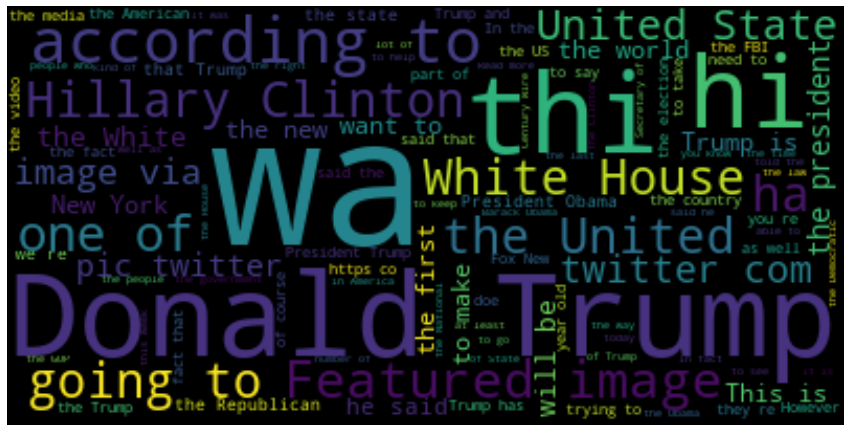

In [6]:
# True news word cloud
true_news_wc = WordCloud(
    background_color='black', 
    max_words=200, 
    stopwords=stopwords
).generate(''.join(true_news_df['text']))


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 18))
ax.imshow(true_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('True News')

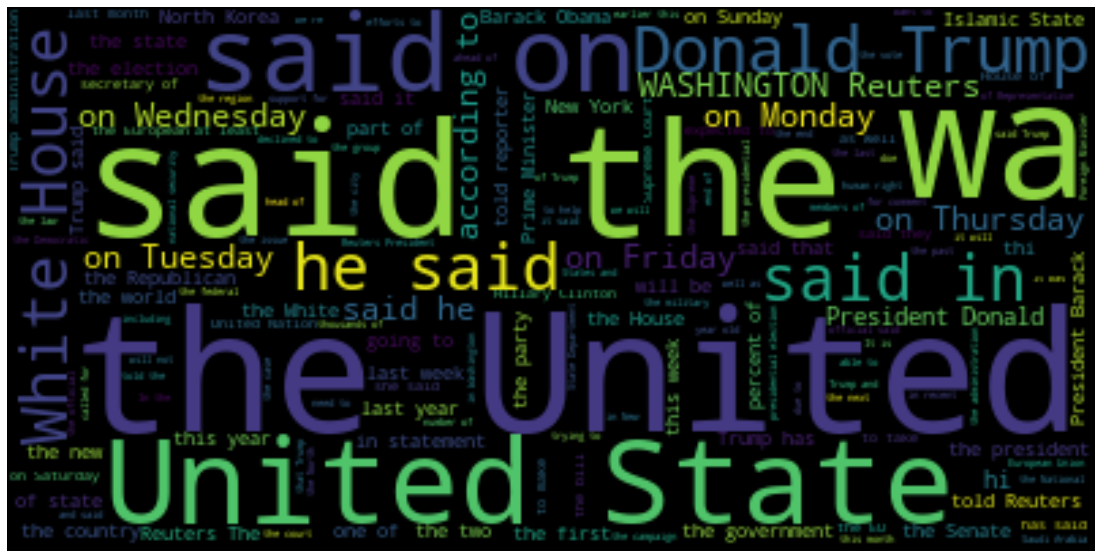

In [7]:
# Fake news word cloud
fake_news_wc = WordCloud(
    background_color='black', 
    max_words=200, 
    stopwords=stopwords
).generate(''.join(fake_news_df['text']))

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.imshow(fake_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Fake News')

## **🚿🛁🧽 Data preprocessing**

### **🤖 Helper Functions**

In [8]:
def convert_from_list_to_text(_list):
    text = ' '.join(_list)
    return text


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **👀 Unique words from text**

In [9]:
def unique(text):
    text = text.split()
    return list(set(text))

In [10]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: unique(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: unique(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Getting rid of 💲❓❗😫punctuations**

In [11]:
# Remove punctuation from a word if it exist
def rm_punc_from_word(word):
    clean_word = ''                # word without punctuation
    for alpha in word:
        # checking if alphabet is punctuation or not
        if alpha in string.punctuation:
            continue
        clean_word += alpha
        
    return clean_word


# Remove any punctuation and clean words having punctuation
def clean_punc(words_list):
    for idx, word in enumerate(words_list):
        if word in string.punctuation:
            words_list.remove(word)
        else:
            words_list[idx] = rm_punc_from_word(word)
            words_list[idx] = re.sub('[0-9]+', '', words_list[idx])
            
    return words_list

In [12]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: clean_punc(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: clean_punc(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Remove numbers 🥱**

In [13]:
def rm_num(words_list):
    text = ' '.join(words_list)
    text = ''.join([i for i in text if not i.isdigit()])
    return text.split()

In [14]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: rm_num(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: rm_num(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Tokenization (⌐■_■)**

In [15]:
def tokenization(words_list):
    tmp = words_list.copy()
    words_list = []
    
    for idx, word in enumerate(tmp):
        for split_word in re.split('\W+', word):
            words_list.append(split_word)

    words_list = ' '.join(words_list).split()  # removing any white spaces
    return words_list

In [16]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: tokenization(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: tokenization(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **😪 Removing URL**

In [17]:
def remove_URL(words_list):
    url = re.compile(r'https?://\S+|www\.\S+')
    for idx, word in enumerate(words_list):
        words_list[idx] = url.sub(r'',word)
    return words_list

In [18]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: remove_URL(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_URL(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Removing 😴 HTML tags**

In [19]:
def remove_HTML(words_list):
    html = re.compile(r'<.*?>')
    for idx, word in enumerate(words_list):
        words_list[idx] = html.sub(r'',word)
    return words_list

In [20]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: remove_HTML(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_HTML(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Remove emoji 🤬 😂**

In [21]:
def remove_emoji(words_list):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    for idx, word in enumerate(words_list):
        words_list[idx] = emoji_pattern.sub(r'',word)
    return words_list

In [22]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: remove_emoji(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: remove_emoji(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[out, clearly, Calvin, Fake, went, gutter, doi...",News,"December 31, 2017"


### **Removing 🛑 stop words**

In [23]:
stopwords = set(nltk.corpus.stopwords.words())

def clean_stopwords(words_list):
    for word in words_list:
        if word in stopwords:
            words_list.remove(word)
    return words_list

In [24]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: clean_stopwords(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: clean_stopwords(x))

true_news_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,"[clearly, Calvin, Fake, went, gutter, When, br...",News,"December 31, 2017"


### **📝Labelling the datasets**

In [25]:
true_news_df['is_fake'] = 0
fake_news_df['is_fake'] = 1

true_news_df.head()

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,"[clearly, Calvin, Fake, went, gutter, When, br...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,"[Australians, May, Hillary, Justice, covfefe, ...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"[When, sheriff, resolve, Black, have, whatsoev...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"[outpace, Bump, course, vs, At, suggests, golf...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,"[forced, May, annual, went, struggled, dialogu...",News,"December 25, 2017",0


### **🙄 Converting list of words to text**

In [26]:
true_news_df['text']  = true_news_df['text'].apply(lambda x: convert_from_list_to_text(x))
fake_news_df['text']  = fake_news_df['text'].apply(lambda x: convert_from_list_to_text(x))

true_news_df.head()

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,clearly Calvin Fake went gutter When breaking ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,Australians May Hillary Justice covfefe Nunes ...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,When sheriff resolve Black have whatsoever hur...,News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,outpace Bump course vs At suggests golf much e...,News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,forced May annual went struggled dialogue an A...,News,"December 25, 2017",0


## **👓Visualizing cleanded data using WordCloud**

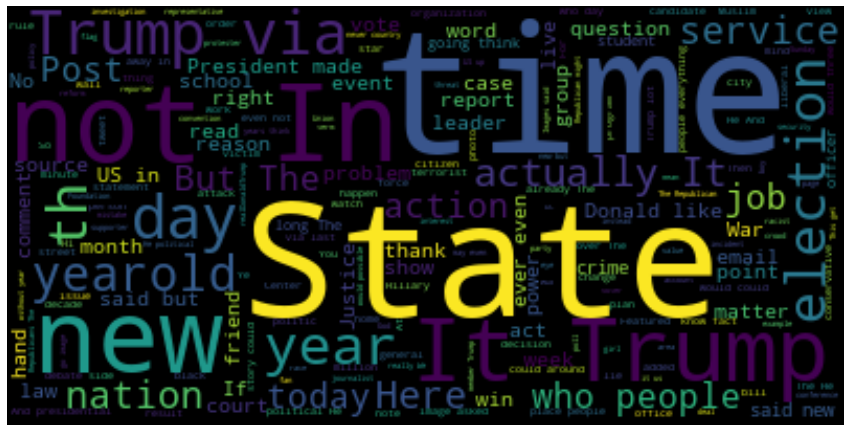

In [27]:
# True news word cloud
true_news_wc = WordCloud(
    background_color='black', 
    max_words=200, 
    stopwords=stopwords
).generate(''.join(true_news_df['text']))


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 18))
ax.imshow(true_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('True News')

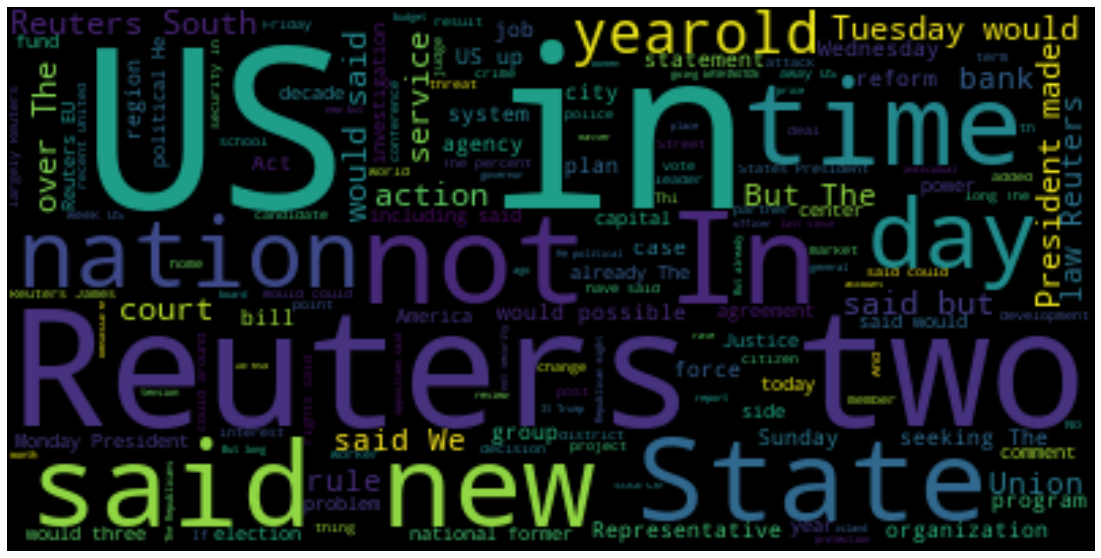

In [28]:
# Fake news word cloud
fake_news_wc = WordCloud(
    background_color='black', 
    max_words=200, 
    stopwords=stopwords
).generate(''.join(fake_news_df['text']))

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.imshow(fake_news_wc, interpolation='bilinear')
ax.axis('off')
ax.set_label('Fake News')

In [29]:
# ✨ Concatenating true and fake news dataframes and suffling them

df = pd.concat([true_news_df, fake_news_df], axis='index')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,title,text,subject,date,is_fake
0,Puerto Rico rescue bill advances to full House...,Governor democratic put protected plan Wednesd...,politicsNews,"May 25, 2016",1
1,WOW! IS SEAN HANNITY’S Job With FOX News In Je...,Sean May comments Murdoch keep interesting inv...,politics,"May 23, 2017",0
2,Donald Trump Has Become So Toxic That He Can’...,Pinto or doing keep among order PoliticoNot hi...,News,"February 9, 2017",0
3,Sally Yates: I Refused To Lie And Say Muslim ...,General or Justice convened went staffers be s...,News,"June 28, 2017",0
4,Britain says expects most EU citizens can stay...,an applications refused million settled stream...,worldnews,"November 7, 2017",1


## **🚀 Creating model**

In [30]:
# 🔪 Splitting the dataset into train & test

skf = StratifiedKFold(n_splits=10)

X = df.text
Y = df.is_fake

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=212)

#### **🧲 Extracting features from text**

🤔 Texts are actually series of words. In order to run machine learning algorithms we need to convert the text of text into numerical feature vectors.

We have used the bag of words model for our example.

🤨 Briefly, we segment each text into words (for English splitting by space), **and count number of times each word occurs in each document and finally assign each word an integer id**. Each unique word in our dictionary will correspond to a feature (descriptive feature).

😏 Scikit-learn has a high level component CountVectorizer which will create feature vectors.

In [31]:
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)

X_train_counts.shape

(40408, 200266)

#### **TF:**

Just counting the number of words in each text has 1 😱 issue: it will give more weightage to longer texts than shorter texts. To avoid this, we can use frequency **(TF - Term Frequencies) i.e. #count(word) / #Total words**, in each  text.

#### **TF-IDF:**

Finally, we have reduce the weightage of more common words like (the, is, an etc.) which occurs in all text. This is called as **TF-IDF i.e Term Frequency times inverse document frequency**.

**To achieve this 😎 TfidfTransformerfrom Scikit-learn is used**.

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_tfidf.shape

(40408, 200266)

### **🎯 Cross Validation**

In [33]:
score = cross_val_score(MultinomialNB(), X_train_tfidf, y_train, cv=skf)
print(f'MultinomialNB mean of cross validation score: {score.mean()}')

score = cross_val_score(LogisticRegression(), X_train_tfidf, y_train, cv=skf)
print(f'LogisticRegression mean of cross validation score: {score.mean()}')

score = cross_val_score(LinearSVC(), X_train_tfidf, y_train, cv=skf)
print(f'LinearSVC mean of cross validation score: {score.mean()}')

MultinomialNB mean of cross validation score: 0.9467679613172898
LogisticRegression mean of cross validation score: 0.9912393204799322
LinearSVC mean of cross validation score: 0.9971787629765204


## **🎰 Pipeline**

In [34]:
model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

### **😎 Fitting the model**

In [35]:
model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

### **🔮 Predictions**

In [36]:
y_test_pred = model.predict(X_test)
np.mean(y_test_pred == y_test)

0.9975501113585746

### **🎯 Metrics**

In [37]:
print(f'Model Score: {model.score(X_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9975501113585746
f1-score: 0.9975500628288545
precision score: 0.9975509057784663
recall score: 0.9975501113585746


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2310
           1       1.00      1.00      1.00      2180

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Confusion matrix, without normalization
[[2306    4]
 [   7 2173]]


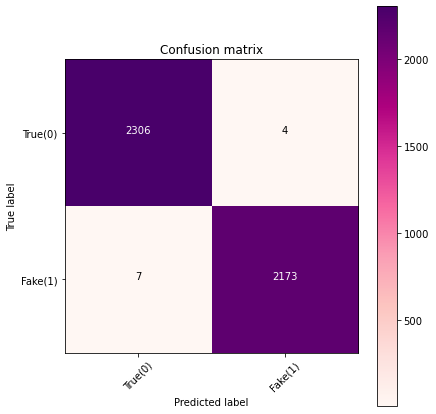

In [38]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0,1])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_test_pred))

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['True(0)', 'Fake(1)'],normalize= False,  title='Confusion matrix', cmap=plt.cm.RdPu)

---